# Finetune semantic change detection

In [44]:
import os

import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.enums import Resampling
import yaml
from einops import rearrange

from prithvi_100m.Prithvi import MaskedAutoencoderViT
from dataset import load_raster


In [5]:
def load_raster(path, out_size=None):
    with rasterio.open(path) as src:
        if out_size:
            out_shape = (
                src.count,
                out_size,
                out_size
            )
        else:
            out_shape = None
            
        img = src.read(
            out_shape=out_shape,
            resampling=Resampling.bilinear
        )

    return img, src

def display_raster(raster):
    _, ax = plt.subplots(figsize=(5,5))
    ax.imshow(raster)

    return ax

<Axes: >

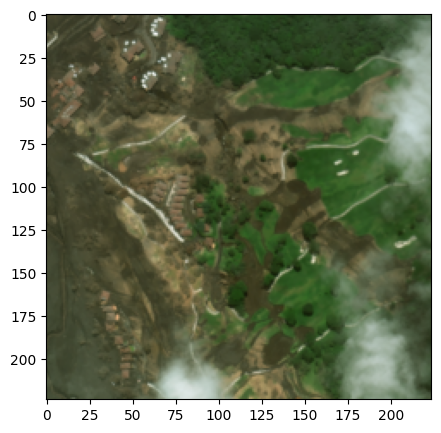

In [11]:
test_path = 'data/geotiffs/hold/images/guatemala-volcano_00000004_post_disaster.tif'

img, src = load_raster(test_path, out_size=224)
display_raster(rearrange(img, 'c h w -> h w c'))

# Load model and weights

In [25]:
# load weights
weights_path = "./prithvi_100m/Prithvi_100M.pt"
checkpoint = torch.load(weights_path, map_location="cpu")

# read model config
model_cfg_path = "./prithvi_100m/Prithvi_100M_config.yaml"
with open(model_cfg_path) as f:
    model_config = yaml.safe_load(f)

model_args, train_args = model_config["model_args"], model_config["train_params"]

# let us use only 1 frame for now (the model was trained on 3 frames)
model_args["num_frames"] = 1

# instantiate model
model = MaskedAutoencoderViT(**model_args)
model.eval()

# load weights into model
# strict=false since we are loading with only 1 frame, but the warning is expected
del checkpoint['pos_embed']
del checkpoint['decoder_pos_embed']
_ = model.load_state_dict(checkpoint, strict=False)

# Prepare Input

In [20]:
# statistics used to normalize images before passing to the model
means = np.mean(img, axis=(1, 2), keepdims=True) # 3x1x1
stds = np.std(img, axis=(1, 2), keepdims=True) # 3x1x1

def preprocess_image(image: np.array):
    # normalize image
    normalized = ((image - means) / stds)

    # add zero-filled IR channels
    normalized = np.concatenate([normalized, np.zeros((3, 224, 224))], axis=0)
    
    normalized = torch.from_numpy(normalized.reshape(1, normalized.shape[0], 1, *normalized.shape[-2:])).to(torch.float32)
    
    
    return normalized

In [21]:
normalized = preprocess_image(img)

In [26]:
features, _, _ = model.forward_encoder(normalized, mask_ratio=0)

In [29]:
print(f"Encoder features have shape {features.shape}")

# drop cls token
reshaped_features = features[:, 1:, :]

# reshape
feature_img_side_length = int(np.sqrt(reshaped_features.shape[1]))
reshaped_features = reshaped_features.view(-1, feature_img_side_length, feature_img_side_length, model_args["embed_dim"])

# channels first
reshaped_features = reshaped_features.permute(0, 3, 1, 2)
print(f"Encoder features have new shape {reshaped_features.shape}")

Encoder features have shape torch.Size([1, 197, 768])
Encoder features have new shape torch.Size([1, 768, 14, 14])


# Segmentation head

In [39]:
num_classes = 4 # No damage, minor, major, destroyed

def upscaling_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Upsample(scale_factor=2), 
        nn.Conv2d(kernel_size=3, in_channels=in_channels, out_channels=out_channels, padding=1),
        nn.ReLU()
    )

embed_dims = [model_args["embed_dim"] // (2**i) for i in range(5)]

segmentation_head = nn.Sequential(
    *[upscaling_block(embed_dims[i], embed_dims[i+1]) for i in range(4)],
    nn.Conv2d(kernel_size=1, in_channels=embed_dims[-1], out_channels=num_classes)
)


In [38]:
segmentation_head(reshaped_features).shape

torch.Size([1, 5, 224, 224])

# Train